# **Projet_ISID : Users Tweet's Predictor**

# **1.Import the libraries**

In [2]:

#other 
import string
import numpy as np
import random
import pandas as pd
from datetime import datetime
from string import punctuation
import matplotlib.pyplot as plt 
import re 
import matplotlib.dates as mdates

#nltk
import nltk
from nltk.corpus import stopwords
from nltk.corpus import words
from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer

#sklearn
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

#wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


## Plotly
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding

In [3]:
nltk.download("stopwords") 
nltk.download('words')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# **2.Importing the  Data**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
dataframe= pd.read_csv('/content/drive/My Drive/Projet_isid/elonmusk_tweets.csv')

In [6]:
dataframe.head()

id  ...                                               text
0  849636868052275200  ...  b'And so the robots spared humanity ... https:...
1  848988730585096192  ...  b"@ForIn2020 @waltmossberg @mims @defcon_5 Exa...
2  848943072423497728  ...      b'@waltmossberg @mims @defcon_5 Et tu, Walt?'
3  848935705057280001  ...                b'Stormy weather in Shortville ...'
4  848416049573658624  ...  b"@DaveLeeBBC @verge Coal is dying due to nat ...

[5 rows x 3 columns]

# **3.Data Preprocessing**

## **3.1Data Cleaning**

In [0]:
df= dataframe.copy()

In [0]:
  df["created_at"] = pd.to_datetime(df.created_at, errors='coerce')

In [92]:
df.dtypes

id                     int64
created_at    datetime64[ns]
text                  object
dtype: object

In [93]:

#Extract the date from the date column

df["Date"] = [datetime.date(d) for d in df["created_at"]]

# Extract the year from the date column just to make sure
df["Time"] = [datetime.time(d) for d in df["created_at"]]

# Take a look at the new columns to make sure everything is okay
df[["created_at", "Date" , "Time"]].head()

created_at        Date      Time
0 2017-04-05 14:56:29  2017-04-05  14:56:29
1 2017-04-03 20:01:01  2017-04-03  20:01:01
2 2017-04-03 16:59:35  2017-04-03  16:59:35
3 2017-04-03 16:30:19  2017-04-03  16:30:19
4 2017-04-02 06:05:23  2017-04-02  06:05:23

In [0]:
df = df.drop(["created_at","id","Time"], axis=1)


In [95]:
df.head()

text        Date
0  b'And so the robots spared humanity ... https:...  2017-04-05
1  b"@ForIn2020 @waltmossberg @mims @defcon_5 Exa...  2017-04-03
2      b'@waltmossberg @mims @defcon_5 Et tu, Walt?'  2017-04-03
3                b'Stormy weather in Shortville ...'  2017-04-03
4  b"@DaveLeeBBC @verge Coal is dying due to nat ...  2017-04-02

In [0]:

STOPWORDS = set(stopwords.words('english'))
punct = ",?.\:!_"
def clean_text(text):
    # lowercase text
    text = text.lower() 
    #delete puncuation 
    #we have to make sure that we keep # which highlites important topics and delete whole @... since it represents a user and hyperlinks

    #text = ''.join([c for c in text if c not in punctuation])
    text = ''.join([c for c in text if c not in punct])
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
   
    #[word.strip(string.punctuation) for word in phrase.split(" ")]
    return text

df['text'] = df['text'].apply(clean_text)

In [97]:
df.head()

text        Date
0  b'and robots spared humanity https//tco/v7jujq...  2017-04-05
1  b"@forin2020 @waltmossberg @mims @defcon5 exac...  2017-04-03
2         b'@waltmossberg @mims @defcon5 et tu walt'  2017-04-03
3                      b'stormy weather shortville '  2017-04-03
4  b"@daveleebbc @verge coal dying due nat gas fr...  2017-04-02

In [0]:
def delete_useless(text):
   l= text.split()
   ch = " ".join([w for w in l if w.startswith('@') == False])
   ch = "".join([w for w in ch if w != '@'])
   ch = "".join([w for w in ch if not w.startswith('https')])
   #deleting hyperlinks 
   
   li = []
   for w in ch.split():
       new = re.sub(r'^https?:\/\/.*[\r\n]*', '', w, flags=re.MULTILINE)
       li.append(new)
   ch1 = " ".join(li)
   return ch1

df['text'] = df['text'].apply(delete_useless)

In [99]:
df.head()

text        Date
0  b'and robots spared humanity https//tco/v7jujq...  2017-04-05
1  b"forin2020 exactly tesla absurdly overvalued ...  2017-04-03
2                         b'waltmossberg et tu walt'  2017-04-03
3                      b'stormy weather shortville '  2017-04-03
4  b"daveleebbc coal dying due nat gas fracking b...  2017-04-02

In [0]:
def apostrophe(text):
  
  ch ="" 
  my_list =[]
  for word in text.split() :
      if  '\'' in word :
         #print(word)
         index = word.index('\'')
         #print(index)
         ch = word[index+1:]
         #print(ch)
         my_list.append(ch)
         #print(my_list)
      elif '\"' in word :
        index = word.index('\"')
        ch = word[index+1:]
        my_list.append(ch)
      else:
         my_list.append(word)

  text = " ".join(my_list)
  return text



df['text'] = df['text'].apply(apostrophe)
  

In [101]:
df.head()

text        Date
0                        and robots spared humanity   2017-04-05
1  forin2020 exactly tesla absurdly overvalued ba...  2017-04-03
2                                waltmossberg et tu   2017-04-03
3                         stormy weather shortville   2017-04-03
4  daveleebbc coal dying due nat gas fracking bas...  2017-04-02

# **4.Data Normalization **




In [0]:
### Create sequence
vocabulary_size = 20000
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(df['text'])



### Stemming

In [0]:
'''

stemmer = PorterStemmer()
def stemming(text):

   new_str= ""
   #words_stem = [stemmer.stem(word) for word in df2['text'][5]]
   for w in text:
       new_str += stemmer.stem(w) 
   
   return new_str
'''

## **4.1.Lemmatizing**

In [0]:
 #(pos_tag(df.text[0].split()))

def lemmatize_sentence(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized_sentence = []
    for word, tag in pos_tag(tokens.split()):
        if tag.startswith('NN'):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        elif tag.startswith('R'):#adverb
            pos =  'r'
        elif tag.startswith('JJ'):#adjec
            pos = 'a'
        else:
            pos = 's'
        lemmatized_sentence.append(lemmatizer.lemmatize(word, pos))
    return " ".join(lemmatized_sentence)

In [104]:
#before
df.head()

text        Date
0                        and robots spared humanity   2017-04-05
1  forin2020 exactly tesla absurdly overvalued ba...  2017-04-03
2                                waltmossberg et tu   2017-04-03
3                         stormy weather shortville   2017-04-03
4  daveleebbc coal dying due nat gas fracking bas...  2017-04-02

In [105]:

#df['text'][:5] = df['text'][:5].apply(lemmatize_sentence)

df['text'] = df['text'].apply(lemmatize_sentence)
df.head()

text        Date
0                            and robot spar humanity  2017-04-05
1  forin2020 exactly tesla absurdly overvalue bas...  2017-04-03
2                                 waltmossberg et tu  2017-04-03
3                          stormy weather shortville  2017-04-03
4  daveleebbc coal die due nat gas fracking basic...  2017-04-02

## Deleting non English Words :

In [0]:

l = []
def remove_non_english(text):

  s = text.split()
  #print(s)
  # s is a list
  new_s  = ""
  for w in s :
    if w in words.words():
      new_s = new_s + w +   " "
   #new_s = "".join([w for w in s if w in words.words()])
    
  return new_s


#df['text'][:5] = df['text'][:5].apply(remove_non_english)


In [0]:

df['text'][:5] = df['text'][:5].apply(remove_non_english)
df.head()

text        Date
0                 and robot spar humanity   2017-04-05
1  exactly absurdly overvalue base past s   2017-04-03
2                                      tu   2017-04-03
3                          stormy weather   2017-04-03
4          coal die due nat gas basically   2017-04-02

# 5.**Keywords** Extraction with **TFIDF** per month

> Bloc en retrait



In [22]:
df.shape

(2819, 2)

In [106]:
corpus = []
for i in range(df.shape[0]):
   docs="".join(df.text[i])
   
   corpus.append(docs)
corpus


['and robot spar humanity',
 'forin2020 exactly tesla absurdly overvalue base past s irrxe2x80xa6',
 'waltmossberg et tu',
 'stormy weather shortville',
 'daveleebbc coal die due nat gas fracking basically',
 'lexxxzis helicopter s',
 'verge',
 'supercoolcube pretty',
 'why waste much time develop silly rocket damn alien obtuse crazy tech t speak',
 'technology breakthrough turn chemtrails actually message time-traveling alien describe secret',
 'rt ve create s first spam-detecting ai train entirely simulation deploy physical robot',
 'rt extremely important - reusable rocket bring us much closer become',
 'adamsbj def p100d ludicrous+ although rocket start go lot faster',
 'badastronomer def bring back like dragon question much weight need',
 'teslaaddict work',
 'jasonlamb look like could 20% structural upgrade handle high load s fully expendable',
 'cheron',
 'cardoso silly thing imagine secret payload 1st dragon flight giant wheel cheese inspire bxe2x80xa6',
 'redletterdave good po

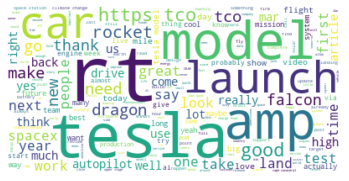

In [108]:

wordcloud = WordCloud(  background_color="white").generate(" ".join(corpus))

# Display the generated image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [109]:
#Bag of words
#create a vocabulary of words, 
cv=CountVectorizer()
word_count_vector=cv.fit_transform(corpus)
print(word_count_vector.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [110]:
list(cv.vocabulary_.keys())[:10]

['and',
 'robot',
 'spar',
 'humanity',
 'forin2020',
 'exactly',
 'tesla',
 'absurdly',
 'overvalue',
 'base']

In [111]:

tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_vector)
 

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [0]:
#d_test=df['text'].tolist()
#d_test

In [112]:

feature_names=cv.get_feature_names()

feature_names

['00',
 '000km',
 '008',
 '01',
 '02',
 '04uqqu0fza',
 '05',
 '06',
 '07',
 '095whwmtkp',
 '095whx44bx',
 '0kgddcvzv0',
 '0lhnzebdqh',
 '0mw11sanwl',
 '0ndqpby3re',
 '0p1hxlw12u',
 '0q3jq1ywjg',
 '10',
 '100',
 '1000',
 '100000',
 '1000lb',
 '1000m',
 '1000th',
 '1001am',
 '100d',
 '100k',
 '100mwh',
 '100s',
 '100t',
 '100th',
 '101',
 '1010',
 '1021am',
 '1027pm',
 '1029am',
 '1032am',
 '105',
 '105f',
 '106',
 '109',
 '10b',
 '10cm',
 '10k',
 '10m',
 '10th',
 '10x',
 '11',
 '110',
 '111',
 '112',
 '1130',
 '115',
 '1187m',
 '11am',
 '11b',
 '11pm',
 '12',
 '120',
 '1200',
 '1202m',
 '121am',
 '122',
 '124000',
 '1245am',
 '1247',
 '126',
 '126am',
 '12m',
 '12v',
 '13',
 '130',
 '130pm',
 '13b',
 '14',
 '140',
 '142pm',
 '145pm',
 '14b',
 '15',
 '150',
 '1500',
 '150000',
 '1501',
 '150km',
 '155',
 '16',
 '160',
 '160km',
 '165',
 '1659',
 '16th',
 '17',
 '170',
 '171m',
 '17775',
 '17m',
 '17th',
 '18',
 '180',
 '1800',
 '180000',
 '18th',
 '19',
 '1927',
 '1941',
 '194cierj',
 '1

In [0]:
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results
 
 

In [114]:
corpus[:2]

['and robot spar humanity',
 'forin2020 exactly tesla absurdly overvalue base past s irrxe2x80xa6']

In [115]:
df.head()

text        Date
0                            and robot spar humanity  2017-04-05
1  forin2020 exactly tesla absurdly overvalue bas...  2017-04-03
2                                 waltmossberg et tu  2017-04-03
3                          stormy weather shortville  2017-04-03
4  daveleebbc coal die due nat gas fracking basic...  2017-04-02

In [116]:
#Goal : 
'''
-------------------return ---------------------
list_dates = {2017: doc1, doc2... , 2018 : doc5,doc10.........}

'''
list_dates = []
last_year = df.Date[0].year
dict ={}
list_of_same_year = []
for index, row in df.iterrows():
    #print(row['Date'], row['text'])
    year = row['Date'].year
    #print(year)
    # if the same year add it to last key and append , else change key
   
    if last_year == year:
       list_of_same_year.append(row['text'])
       print(list_of_same_year)
       dict[year] = list_of_same_year # {2014: doc , doc}
       print(dict)

    else:
       list_of_same_year = []
       l =list_of_same_year
       l.append(row['text'])
       dict[year] = l
       
#list_dates.append(dict)
#list_dates

dict
    


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



{2010: ['please ignore prior tweet someone pretend ) actually'],
 2011: ['go iceland sit ride bumper car ice country s rink van nuys awesome family fun )'],
 2012: ['my first prediction 2012 come true ouch head'],
 2013: ['this give sense mar would look like change climate sustain life'],
 2014: ['prepare launch thaicom satellite geostationary super-sync orbit 5pm florida time'],
 2015: ['rt 2014 includedn6 falcon 9 launch xe2x9cx93ncrew dragon unveiling xe2x9cx93nsoft land 1st stage s revolutionary'],
 2016: ['falcon 9 back hangar cape canaveral damage find ready fire'],
 2017: ['and robot spar humanity',
  'forin2020 exactly tesla absurdly overvalue base past s irrxe2x80xa6',
  'waltmossberg et tu',
  'stormy weather shortville',
  'daveleebbc coal die due nat gas fracking basically',
  'lexxxzis helicopter s',
  'verge',
  'supercoolcube pretty',
  'why waste much time develop silly rocket damn alien obtuse crazy tech t speak',
  'technology breakthrough turn chemtrails actually mes

In [117]:
for year,docs in dict.items():
 
    #generate tf-idf for the given document
    '''for doc in list(docs):
      print(doc)
      break'''
    print(docs)

['and robot spar humanity', 'forin2020 exactly tesla absurdly overvalue base past s irrxe2x80xa6', 'waltmossberg et tu', 'stormy weather shortville', 'daveleebbc coal die due nat gas fracking basically', 'lexxxzis helicopter s', 'verge', 'supercoolcube pretty', 'why waste much time develop silly rocket damn alien obtuse crazy tech t speak', 'technology breakthrough turn chemtrails actually message time-traveling alien describe secret', 'rt ve create s first spam-detecting ai train entirely simulation deploy physical robot', 'rt extremely important - reusable rocket bring us much closer become', 'adamsbj def p100d ludicrous+ although rocket start go lot faster', 'badastronomer def bring back like dragon question much weight need', 'teslaaddict work', 'jasonlamb look like could 20% structural upgrade handle high load s fully expendable', 'cheron', 'cardoso silly thing imagine secret payload 1st dragon flight giant wheel cheese inspire bxe2x80xa6', 'redletterdave good point odds go 0% &gt

In [0]:
'''
total_keywords = []

for year,docs in dict.items():
 
    #generate tf-idf for the given document
    keywords_per_year = []
    print('-----------------for year',year,'those are the keywords:-----------------------------')
    for doc in docs:
        tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))
 
        #sort the tf-idf vectors by descending order of scores
        sorted_items=sort_coo(tf_idf_vector.tocoo())
 
        #extract only the top n; n here is 10
        #keywords=extract_topn_from_vector(feature_names,sorted_items,1)
        #print(keywords)
      
    #keywords_per_year.append(keywords)
    keywords_per_year=extract_topn_from_vector(feature_names,sorted_items,10)
    print(keywords_per_year)
    total_keywords.append(keywords_per_year)
    

 
print('----------------total keywords for all the years:--------------------------------\n' ,total_keywords)'''

-----------------for year 2017 those are the keywords:-----------------------------
{'vandenberg': 0.38, 'down': 0.38, 'force': 0.326, 'complete': 0.298, 'hold': 0.294, 'air': 0.29, 'fire': 0.277, 'system': 0.273, 'next': 0.231, 'go': 0.222}
-----------------for year 2016 those are the keywords:-----------------------------
{'hangar': 0.419, 'damage': 0.407, 'ready': 0.363, 'find': 0.32, 'canaveral': 0.318, 'cape': 0.309, 'fire': 0.297, 'back': 0.289, 'falcon': 0.237}
-----------------for year 2015 those are the keywords:-----------------------------
{'xe2x9cx93nsoft': 0.368, 'xe2x9cx93ncrew': 0.368, 'includedn6': 0.368, 'revolutionary': 0.35, 'unveiling': 0.319, '2014': 0.301, '1st': 0.257, 'stage': 0.231, 'land': 0.2, 'falcon': 0.191}
-----------------for year 2014 those are the keywords:-----------------------------
{'sync': 0.378, 'geostationary': 0.36, '5pm': 0.346, 'thaicom': 0.336, 'prepare': 0.336, 'florida': 0.328, 'super': 0.261, 'satellite': 0.254, 'orbit': 0.254, 'time': 0.

In [118]:

total_keywords = []
dict1 = {}
years = []
for year,docs in dict.items():
    years.append(year)
    #generate tf-idf for the given document
    keywords_per_year = []
    print('-----------------for year',year,'those are the keywords:-----------------------------')
    for doc in docs:
        tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))
 
        #sort the tf-idf vectors by descending order of scores
        sorted_items=sort_coo(tf_idf_vector.tocoo())
 
        #extract only the top n; n here is 10
        #keywords=extract_topn_from_vector(feature_names,sorted_items,1)
        #print(keywords)
      
    #keywords_per_year.append(keywords)
    keywords_per_year=extract_topn_from_vector(feature_names,sorted_items,10)
    print(keywords_per_year)
    dict1[year] = keywords_per_year
    total_keywords.append(dict1)
    

 
print('----------------total keywords for all the years:--------------------------------\n' ,total_keywords)

-----------------for year 2017 those are the keywords:-----------------------------
{'vandenberg': 0.38, 'down': 0.38, 'force': 0.326, 'complete': 0.298, 'hold': 0.294, 'air': 0.29, 'fire': 0.277, 'system': 0.273, 'next': 0.231, 'go': 0.222}
-----------------for year 2016 those are the keywords:-----------------------------
{'hangar': 0.419, 'damage': 0.407, 'ready': 0.363, 'find': 0.32, 'canaveral': 0.318, 'cape': 0.309, 'fire': 0.297, 'back': 0.289, 'falcon': 0.237}
-----------------for year 2015 those are the keywords:-----------------------------
{'xe2x9cx93nsoft': 0.368, 'xe2x9cx93ncrew': 0.368, 'includedn6': 0.368, 'revolutionary': 0.35, 'unveiling': 0.319, '2014': 0.301, '1st': 0.257, 'stage': 0.231, 'land': 0.2, 'falcon': 0.191}
-----------------for year 2014 those are the keywords:-----------------------------
{'sync': 0.378, 'geostationary': 0.36, '5pm': 0.346, 'thaicom': 0.336, 'prepare': 0.336, 'florida': 0.328, 'super': 0.261, 'satellite': 0.254, 'orbit': 0.254, 'time': 0.

In [119]:
years.sort()
years

[2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]

In [120]:
#we have to make total_keywords{2017: [doc1,doc3]; 2018 : [doc11,...], ,}
for i in total_keywords:
  print(list(i.keys()))




[2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010]
[2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010]
[2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010]
[2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010]
[2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010]
[2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010]
[2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010]
[2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010]


In [121]:
total_keywords

[{2010: {'actually': 0.292,
   'ignore': 0.456,
   'please': 0.328,
   'pretend': 0.433,
   'prior': 0.386,
   'someone': 0.372,
   'tweet': 0.352},
  2011: {'bumper': 0.313,
   'family': 0.271,
   'fun': 0.248,
   'ice': 0.256,
   'iceland': 0.313,
   'nuys': 0.313,
   'ride': 0.248,
   'rink': 0.313,
   'sit': 0.313,
   'van': 0.313},
  2012: {'2012': 0.383,
   'come': 0.267,
   'first': 0.245,
   'head': 0.335,
   'my': 0.345,
   'ouch': 0.452,
   'prediction': 0.43,
   'true': 0.318},
  2013: {'change': 0.28,
   'climate': 0.29,
   'give': 0.293,
   'life': 0.303,
   'look': 0.238,
   'mar': 0.267,
   'sense': 0.344,
   'sustain': 0.439,
   'this': 0.332,
   'would': 0.247},
  2014: {'5pm': 0.346,
   'florida': 0.328,
   'geostationary': 0.36,
   'orbit': 0.254,
   'prepare': 0.336,
   'satellite': 0.254,
   'super': 0.261,
   'sync': 0.378,
   'thaicom': 0.336,
   'time': 0.211},
  2015: {'1st': 0.257,
   '2014': 0.301,
   'falcon': 0.191,
   'includedn6': 0.368,
   'land': 0.2,
 

In [0]:
#total_keywords [{217:{...},2018:........}]

'''for di in total_keywords:
  #di is a dictionary
  new_sorted_dict=[]
  d1={}
  for key in sorted(di.keys()):
    print(key)
    print(di[key])
    d1[key] = di[key]
    new_sorted_dict.append(d1)

new_sorted_dict

'''

2010
{'ignore': 0.456, 'pretend': 0.433, 'prior': 0.386, 'someone': 0.372, 'tweet': 0.352, 'please': 0.328, 'actually': 0.292}
2011
{'van': 0.313, 'sit': 0.313, 'rink': 0.313, 'nuys': 0.313, 'iceland': 0.313, 'bumper': 0.313, 'family': 0.271, 'ice': 0.256, 'ride': 0.248, 'fun': 0.248}
2012
{'ouch': 0.452, 'prediction': 0.43, '2012': 0.383, 'my': 0.345, 'head': 0.335, 'true': 0.318, 'come': 0.267, 'first': 0.245}
2013
{'sustain': 0.439, 'sense': 0.344, 'this': 0.332, 'life': 0.303, 'give': 0.293, 'climate': 0.29, 'change': 0.28, 'mar': 0.267, 'would': 0.247, 'look': 0.238}
2014
{'sync': 0.378, 'geostationary': 0.36, '5pm': 0.346, 'thaicom': 0.336, 'prepare': 0.336, 'florida': 0.328, 'super': 0.261, 'satellite': 0.254, 'orbit': 0.254, 'time': 0.211}
2015
{'xe2x9cx93nsoft': 0.368, 'xe2x9cx93ncrew': 0.368, 'includedn6': 0.368, 'revolutionary': 0.35, 'unveiling': 0.319, '2014': 0.301, '1st': 0.257, 'stage': 0.231, 'land': 0.2, 'falcon': 0.191}
2016
{'hangar': 0.419, 'damage': 0.407, 'ready'

[{2010: {'actually': 0.292,
   'ignore': 0.456,
   'please': 0.328,
   'pretend': 0.433,
   'prior': 0.386,
   'someone': 0.372,
   'tweet': 0.352},
  2011: {'bumper': 0.313,
   'family': 0.271,
   'fun': 0.248,
   'ice': 0.256,
   'iceland': 0.313,
   'nuys': 0.313,
   'ride': 0.248,
   'rink': 0.313,
   'sit': 0.313,
   'van': 0.313},
  2012: {'2012': 0.383,
   'come': 0.267,
   'first': 0.245,
   'head': 0.335,
   'my': 0.345,
   'ouch': 0.452,
   'prediction': 0.43,
   'true': 0.318},
  2013: {'change': 0.28,
   'climate': 0.29,
   'give': 0.293,
   'life': 0.303,
   'look': 0.238,
   'mar': 0.267,
   'sense': 0.344,
   'sustain': 0.439,
   'this': 0.332,
   'would': 0.247},
  2014: {'5pm': 0.346,
   'florida': 0.328,
   'geostationary': 0.36,
   'orbit': 0.254,
   'prepare': 0.336,
   'satellite': 0.254,
   'super': 0.261,
   'sync': 0.378,
   'thaicom': 0.336,
   'time': 0.211},
  2015: {'1st': 0.257,
   '2014': 0.301,
   'falcon': 0.191,
   'includedn6': 0.368,
   'land': 0.2,
 

In [122]:
years_list = []
for date in df.Date:
  #print(type(date.year))
  years_list.append(date.year)
  

years_list =  list( set(years_list))
years_list



[2016, 2017, 2010, 2011, 2012, 2013, 2014, 2015]

In [123]:
years_list.sort()
years_list

[2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]

In [124]:
#total_keywords [{217:{...},2018:........}]


keywords_years_dict = {}
for yearr in years_list:
  
  for di in total_keywords[:5]: #di is a dict containg all years with corresponding keywpords
      
      
      for current_year in sorted(di.keys()):
       
        if current_year == yearr:
          #print(current_year)
          #print(keywords_years_dict)
          if current_year in keywords_years_dict :
            keywords_years_dict[current_year] = [keywords_years_dict[current_year],di[current_year]]
            #print(True,keywords_years_dict)
          
          keywords_years_dict[current_year] = di[current_year]
          #print(False,keywords_years_dict)

        else:
           continue
 
  
      
          
        
      
      #keywords_years_list.append(keywords_years_dict)
  
keywords_years_dict





{2010: {'actually': 0.292,
  'ignore': 0.456,
  'please': 0.328,
  'pretend': 0.433,
  'prior': 0.386,
  'someone': 0.372,
  'tweet': 0.352},
 2011: {'bumper': 0.313,
  'family': 0.271,
  'fun': 0.248,
  'ice': 0.256,
  'iceland': 0.313,
  'nuys': 0.313,
  'ride': 0.248,
  'rink': 0.313,
  'sit': 0.313,
  'van': 0.313},
 2012: {'2012': 0.383,
  'come': 0.267,
  'first': 0.245,
  'head': 0.335,
  'my': 0.345,
  'ouch': 0.452,
  'prediction': 0.43,
  'true': 0.318},
 2013: {'change': 0.28,
  'climate': 0.29,
  'give': 0.293,
  'life': 0.303,
  'look': 0.238,
  'mar': 0.267,
  'sense': 0.344,
  'sustain': 0.439,
  'this': 0.332,
  'would': 0.247},
 2014: {'5pm': 0.346,
  'florida': 0.328,
  'geostationary': 0.36,
  'orbit': 0.254,
  'prepare': 0.336,
  'satellite': 0.254,
  'super': 0.261,
  'sync': 0.378,
  'thaicom': 0.336,
  'time': 0.211},
 2015: {'1st': 0.257,
  '2014': 0.301,
  'falcon': 0.191,
  'includedn6': 0.368,
  'land': 0.2,
  'revolutionary': 0.35,
  'stage': 0.231,
  'unvei

In [125]:
most_keywords={}
for year,val in keywords_years_dict.items():
  #print(val)
  keys = list(val.keys())[:5]
  d = {k: val[k] for k in keys}
  most_keywords[year] = d
  
most_keywords

{2010: {'ignore': 0.456,
  'pretend': 0.433,
  'prior': 0.386,
  'someone': 0.372,
  'tweet': 0.352},
 2011: {'iceland': 0.313,
  'nuys': 0.313,
  'rink': 0.313,
  'sit': 0.313,
  'van': 0.313},
 2012: {'2012': 0.383,
  'head': 0.335,
  'my': 0.345,
  'ouch': 0.452,
  'prediction': 0.43},
 2013: {'give': 0.293,
  'life': 0.303,
  'sense': 0.344,
  'sustain': 0.439,
  'this': 0.332},
 2014: {'5pm': 0.346,
  'geostationary': 0.36,
  'prepare': 0.336,
  'sync': 0.378,
  'thaicom': 0.336},
 2015: {'includedn6': 0.368,
  'revolutionary': 0.35,
  'unveiling': 0.319,
  'xe2x9cx93ncrew': 0.368,
  'xe2x9cx93nsoft': 0.368},
 2016: {'canaveral': 0.318,
  'damage': 0.407,
  'find': 0.32,
  'hangar': 0.419,
  'ready': 0.363},
 2017: {'complete': 0.298,
  'down': 0.38,
  'force': 0.326,
  'hold': 0.294,
  'vandenberg': 0.38}}

In [0]:
#most_common_5_words_per_year
'''most_keywords = {}
for year , val in keywords_years_dict.items():
 #print(val.keys())
 most_keywords[year] = list(val.keys())[:5]
most_keywords'''

{2010: ['ignore', 'pretend', 'prior', 'someone', 'tweet'],
 2011: ['van', 'sit', 'rink', 'nuys', 'iceland'],
 2012: ['ouch', 'prediction', '2012', 'my', 'head'],
 2013: ['sustain', 'sense', 'this', 'life', 'give'],
 2014: ['sync', 'geostationary', '5pm', 'thaicom', 'prepare'],
 2015: ['xe2x9cx93nsoft',
  'xe2x9cx93ncrew',
  'includedn6',
  'revolutionary',
  'unveiling'],
 2016: ['hangar', 'damage', 'ready', 'find', 'canaveral'],
 2017: ['vandenberg', 'down', 'force', 'complete', 'hold']}

In [126]:
most_keywords

{2010: {'ignore': 0.456,
  'pretend': 0.433,
  'prior': 0.386,
  'someone': 0.372,
  'tweet': 0.352},
 2011: {'iceland': 0.313,
  'nuys': 0.313,
  'rink': 0.313,
  'sit': 0.313,
  'van': 0.313},
 2012: {'2012': 0.383,
  'head': 0.335,
  'my': 0.345,
  'ouch': 0.452,
  'prediction': 0.43},
 2013: {'give': 0.293,
  'life': 0.303,
  'sense': 0.344,
  'sustain': 0.439,
  'this': 0.332},
 2014: {'5pm': 0.346,
  'geostationary': 0.36,
  'prepare': 0.336,
  'sync': 0.378,
  'thaicom': 0.336},
 2015: {'includedn6': 0.368,
  'revolutionary': 0.35,
  'unveiling': 0.319,
  'xe2x9cx93ncrew': 0.368,
  'xe2x9cx93nsoft': 0.368},
 2016: {'canaveral': 0.318,
  'damage': 0.407,
  'find': 0.32,
  'hangar': 0.419,
  'ready': 0.363},
 2017: {'complete': 0.298,
  'down': 0.38,
  'force': 0.326,
  'hold': 0.294,
  'vandenberg': 0.38}}

In [127]:
k_word = []
for val in most_keywords.items():
  #print(val[1])
  d = val[1]
  v= next(iter(d))
  p = (v , (val[1])[v])
  #print(p)
  k_word.append(p)
k_word

[('ignore', 0.456),
 ('van', 0.313),
 ('ouch', 0.452),
 ('sustain', 0.439),
 ('sync', 0.378),
 ('xe2x9cx93nsoft', 0.368),
 ('hangar', 0.419),
 ('vandenberg', 0.38)]

In [128]:
result = pd.DataFrame(columns=['year','keywords'] , data={'year': years_list , 'keywords' : k_word })
result



year                 keywords
0  2010          (ignore, 0.456)
1  2011             (van, 0.313)
2  2012            (ouch, 0.452)
3  2013         (sustain, 0.439)
4  2014            (sync, 0.378)
5  2015  (xe2x9cx93nsoft, 0.368)
6  2016          (hangar, 0.419)
7  2017       (vandenberg, 0.38)

In [0]:
result.to_csv('/content/drive/My Drive/Projet_isid/Y.csv')

# Visualizing keywords using Word Cloud

------------------------PLOT WORDCLOUD FOR YEAR/ 2017 ----------------------------
vandenberg down force complete hold air fire system next go


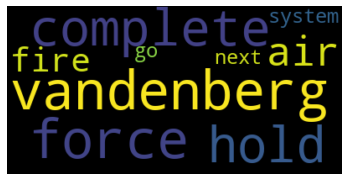

------------------------PLOT WORDCLOUD FOR YEAR/ 2017 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon


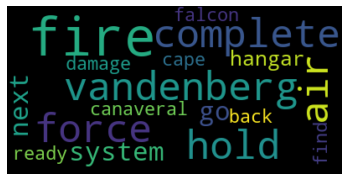

------------------------PLOT WORDCLOUD FOR YEAR/ 2017 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon


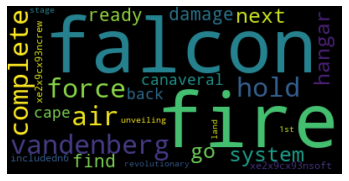

------------------------PLOT WORDCLOUD FOR YEAR/ 2017 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time


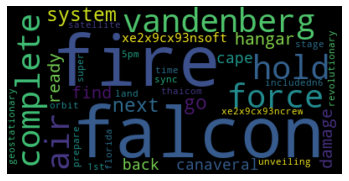

------------------------PLOT WORDCLOUD FOR YEAR/ 2017 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time sustain sense this life give climate change mar would look


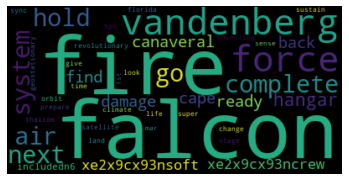

------------------------PLOT WORDCLOUD FOR YEAR/ 2017 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time sustain sense this life give climate change mar would look ouch prediction 2012 my head true come first


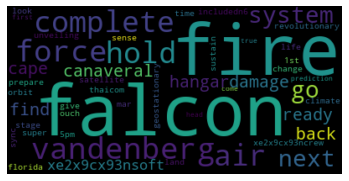

------------------------PLOT WORDCLOUD FOR YEAR/ 2017 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time sustain sense this life give climate change mar would look ouch prediction 2012 my head true come first van sit rink nuys iceland bumper family ice ride fun


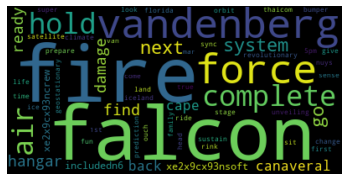

------------------------PLOT WORDCLOUD FOR YEAR/ 2017 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time sustain sense this life give climate change mar would look ouch prediction 2012 my head true come first van sit rink nuys iceland bumper family ice ride fun ignore pretend prior someone tweet please actually


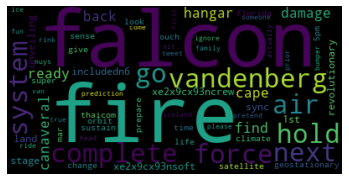

------------------------PLOT WORDCLOUD FOR YEAR/ 2017 ----------------------------
vandenberg down force complete hold air fire system next go


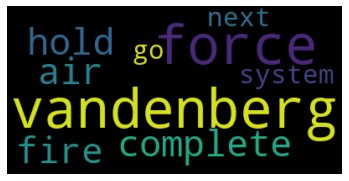

------------------------PLOT WORDCLOUD FOR YEAR/ 2017 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon


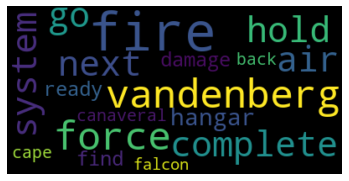

------------------------PLOT WORDCLOUD FOR YEAR/ 2017 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon


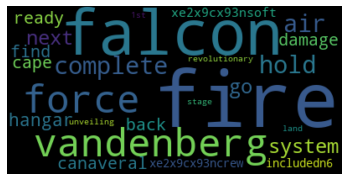

------------------------PLOT WORDCLOUD FOR YEAR/ 2017 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time


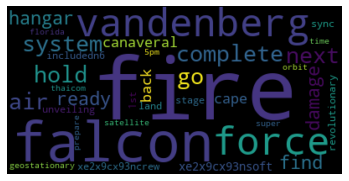

------------------------PLOT WORDCLOUD FOR YEAR/ 2017 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time sustain sense this life give climate change mar would look


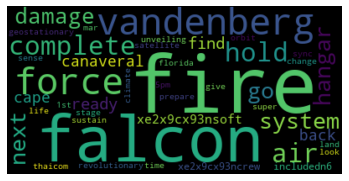

------------------------PLOT WORDCLOUD FOR YEAR/ 2017 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time sustain sense this life give climate change mar would look ouch prediction 2012 my head true come first


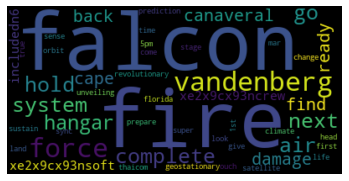

------------------------PLOT WORDCLOUD FOR YEAR/ 2017 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time sustain sense this life give climate change mar would look ouch prediction 2012 my head true come first van sit rink nuys iceland bumper family ice ride fun


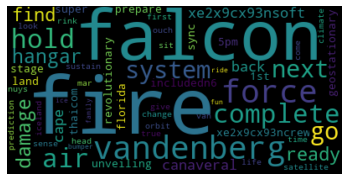

------------------------PLOT WORDCLOUD FOR YEAR/ 2017 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time sustain sense this life give climate change mar would look ouch prediction 2012 my head true come first van sit rink nuys iceland bumper family ice ride fun ignore pretend prior someone tweet please actually


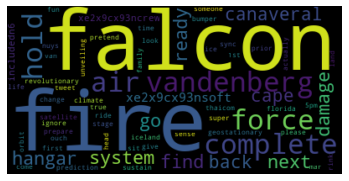

------------------------PLOT WORDCLOUD FOR YEAR/ 2017 ----------------------------
vandenberg down force complete hold air fire system next go


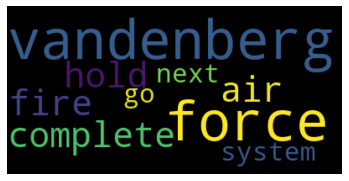

------------------------PLOT WORDCLOUD FOR YEAR/ 2017 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon


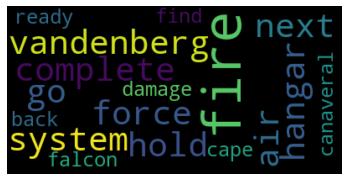

------------------------PLOT WORDCLOUD FOR YEAR/ 2017 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon


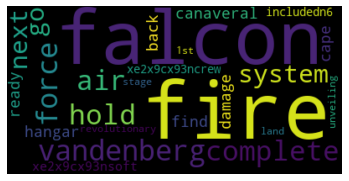

------------------------PLOT WORDCLOUD FOR YEAR/ 2017 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time


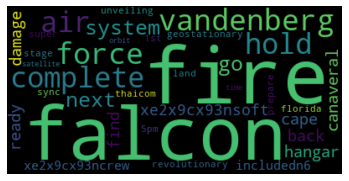

------------------------PLOT WORDCLOUD FOR YEAR/ 2017 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time sustain sense this life give climate change mar would look


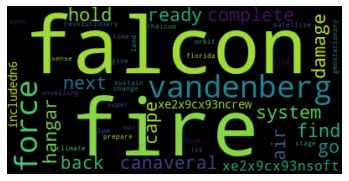

------------------------PLOT WORDCLOUD FOR YEAR/ 2017 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time sustain sense this life give climate change mar would look ouch prediction 2012 my head true come first


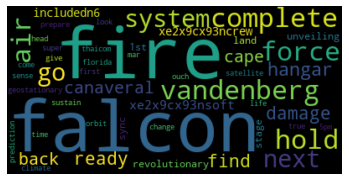

------------------------PLOT WORDCLOUD FOR YEAR/ 2017 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time sustain sense this life give climate change mar would look ouch prediction 2012 my head true come first van sit rink nuys iceland bumper family ice ride fun


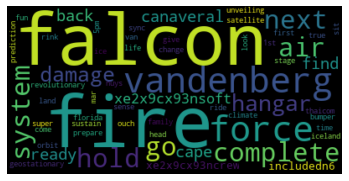

------------------------PLOT WORDCLOUD FOR YEAR/ 2017 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time sustain sense this life give climate change mar would look ouch prediction 2012 my head true come first van sit rink nuys iceland bumper family ice ride fun ignore pretend prior someone tweet please actually


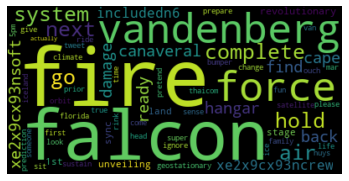

------------------------PLOT WORDCLOUD FOR YEAR/ 2017 ----------------------------
vandenberg down force complete hold air fire system next go


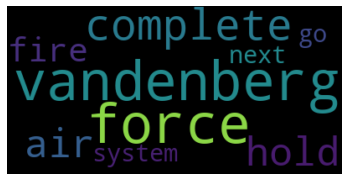

------------------------PLOT WORDCLOUD FOR YEAR/ 2017 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon


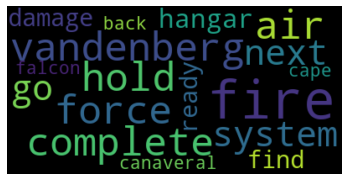

------------------------PLOT WORDCLOUD FOR YEAR/ 2017 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon


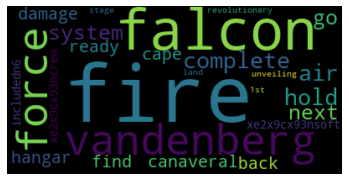

------------------------PLOT WORDCLOUD FOR YEAR/ 2017 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time


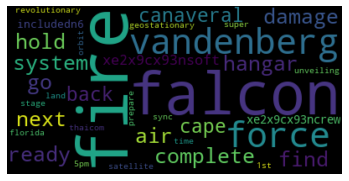

------------------------PLOT WORDCLOUD FOR YEAR/ 2017 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time sustain sense this life give climate change mar would look


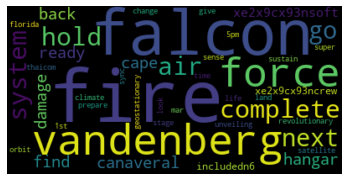

------------------------PLOT WORDCLOUD FOR YEAR/ 2017 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time sustain sense this life give climate change mar would look ouch prediction 2012 my head true come first


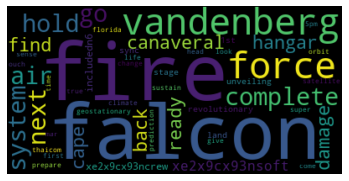

------------------------PLOT WORDCLOUD FOR YEAR/ 2017 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time sustain sense this life give climate change mar would look ouch prediction 2012 my head true come first van sit rink nuys iceland bumper family ice ride fun


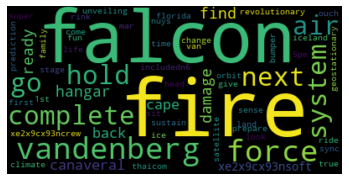

------------------------PLOT WORDCLOUD FOR YEAR/ 2017 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time sustain sense this life give climate change mar would look ouch prediction 2012 my head true come first van sit rink nuys iceland bumper family ice ride fun ignore pretend prior someone tweet please actually


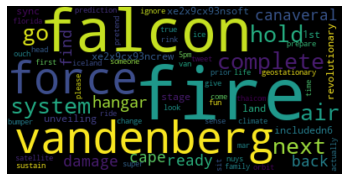

------------------------PLOT WORDCLOUD FOR YEAR/ 2017 ----------------------------
vandenberg down force complete hold air fire system next go


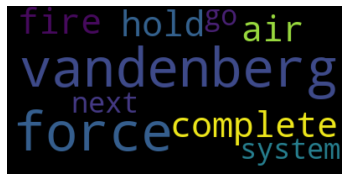

------------------------PLOT WORDCLOUD FOR YEAR/ 2017 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon


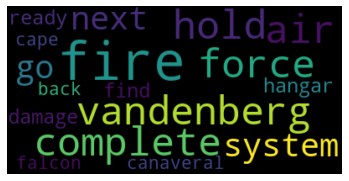

------------------------PLOT WORDCLOUD FOR YEAR/ 2017 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon


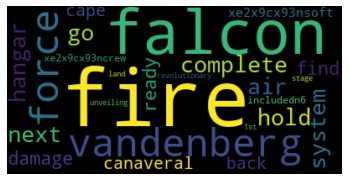

------------------------PLOT WORDCLOUD FOR YEAR/ 2017 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time


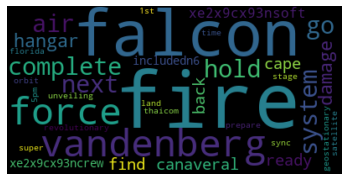

------------------------PLOT WORDCLOUD FOR YEAR/ 2017 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time sustain sense this life give climate change mar would look


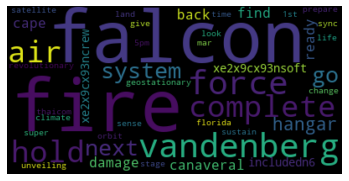

------------------------PLOT WORDCLOUD FOR YEAR/ 2017 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time sustain sense this life give climate change mar would look ouch prediction 2012 my head true come first


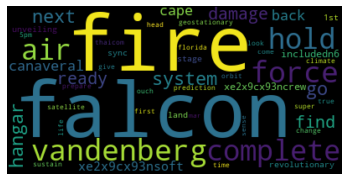

------------------------PLOT WORDCLOUD FOR YEAR/ 2017 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time sustain sense this life give climate change mar would look ouch prediction 2012 my head true come first van sit rink nuys iceland bumper family ice ride fun


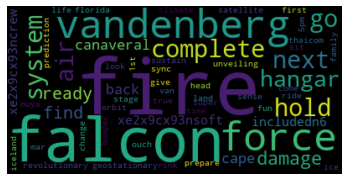

------------------------PLOT WORDCLOUD FOR YEAR/ 2017 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time sustain sense this life give climate change mar would look ouch prediction 2012 my head true come first van sit rink nuys iceland bumper family ice ride fun ignore pretend prior someone tweet please actually


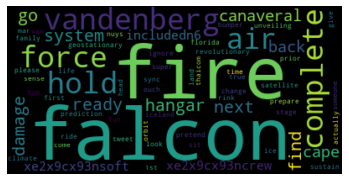

------------------------PLOT WORDCLOUD FOR YEAR/ 2017 ----------------------------
vandenberg down force complete hold air fire system next go


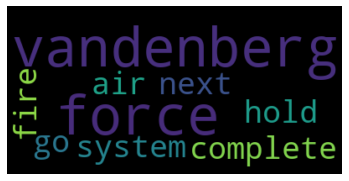

------------------------PLOT WORDCLOUD FOR YEAR/ 2017 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon


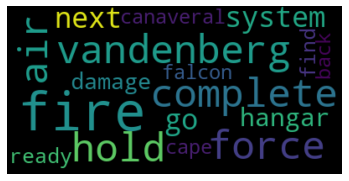

------------------------PLOT WORDCLOUD FOR YEAR/ 2017 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon


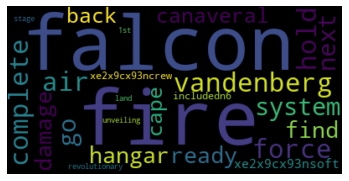

------------------------PLOT WORDCLOUD FOR YEAR/ 2017 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time


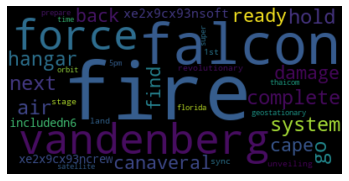

------------------------PLOT WORDCLOUD FOR YEAR/ 2017 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time sustain sense this life give climate change mar would look


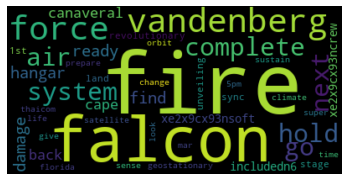

------------------------PLOT WORDCLOUD FOR YEAR/ 2017 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time sustain sense this life give climate change mar would look ouch prediction 2012 my head true come first


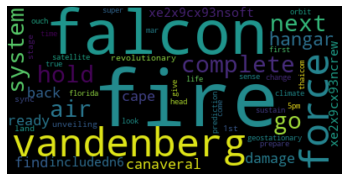

------------------------PLOT WORDCLOUD FOR YEAR/ 2017 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time sustain sense this life give climate change mar would look ouch prediction 2012 my head true come first van sit rink nuys iceland bumper family ice ride fun


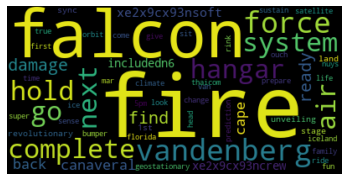

------------------------PLOT WORDCLOUD FOR YEAR/ 2017 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time sustain sense this life give climate change mar would look ouch prediction 2012 my head true come first van sit rink nuys iceland bumper family ice ride fun ignore pretend prior someone tweet please actually


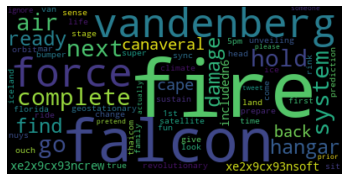

------------------------PLOT WORDCLOUD FOR YEAR/ 2017 ----------------------------
vandenberg down force complete hold air fire system next go


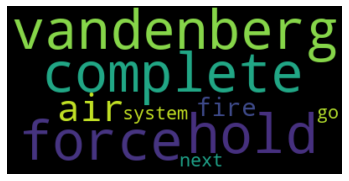

------------------------PLOT WORDCLOUD FOR YEAR/ 2017 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon


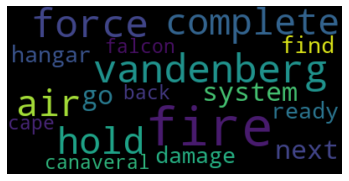

------------------------PLOT WORDCLOUD FOR YEAR/ 2017 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon


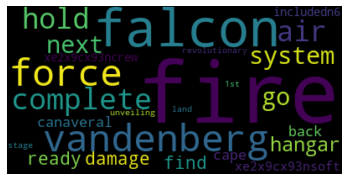

------------------------PLOT WORDCLOUD FOR YEAR/ 2017 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time


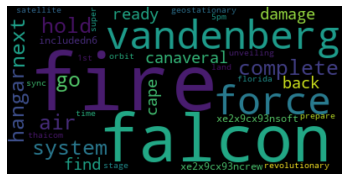

------------------------PLOT WORDCLOUD FOR YEAR/ 2017 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time sustain sense this life give climate change mar would look


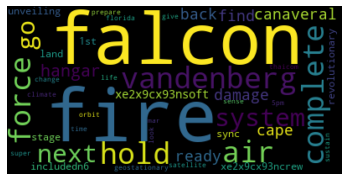

------------------------PLOT WORDCLOUD FOR YEAR/ 2017 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time sustain sense this life give climate change mar would look ouch prediction 2012 my head true come first


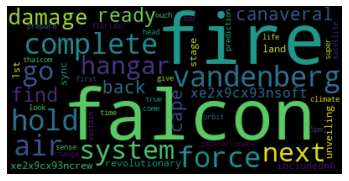

------------------------PLOT WORDCLOUD FOR YEAR/ 2017 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time sustain sense this life give climate change mar would look ouch prediction 2012 my head true come first van sit rink nuys iceland bumper family ice ride fun


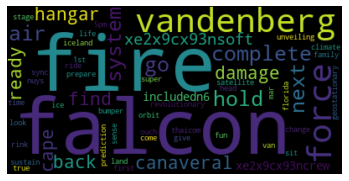

------------------------PLOT WORDCLOUD FOR YEAR/ 2017 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time sustain sense this life give climate change mar would look ouch prediction 2012 my head true come first van sit rink nuys iceland bumper family ice ride fun ignore pretend prior someone tweet please actually


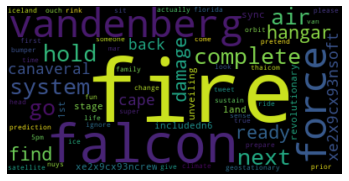

------------------------PLOT WORDCLOUD FOR YEAR/ 2017 ----------------------------
vandenberg down force complete hold air fire system next go


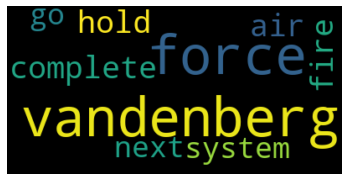

------------------------PLOT WORDCLOUD FOR YEAR/ 2017 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon


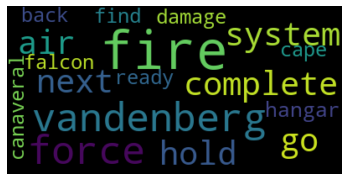

------------------------PLOT WORDCLOUD FOR YEAR/ 2017 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon


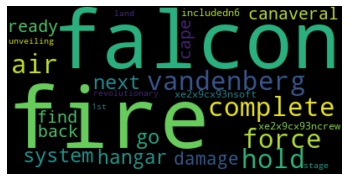

------------------------PLOT WORDCLOUD FOR YEAR/ 2017 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time


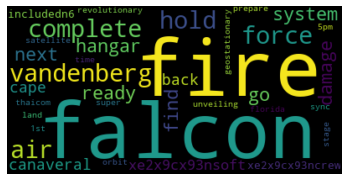

------------------------PLOT WORDCLOUD FOR YEAR/ 2017 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time sustain sense this life give climate change mar would look


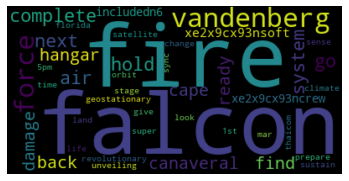

------------------------PLOT WORDCLOUD FOR YEAR/ 2017 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time sustain sense this life give climate change mar would look ouch prediction 2012 my head true come first


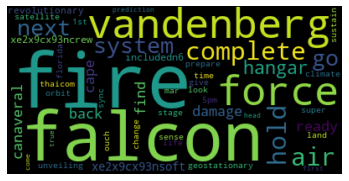

------------------------PLOT WORDCLOUD FOR YEAR/ 2017 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time sustain sense this life give climate change mar would look ouch prediction 2012 my head true come first van sit rink nuys iceland bumper family ice ride fun


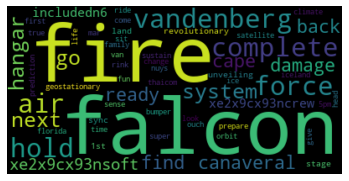

------------------------PLOT WORDCLOUD FOR YEAR/ 2017 ----------------------------
vandenberg down force complete hold air fire system next go hangar damage ready find canaveral cape fire back falcon xe2x9cx93nsoft xe2x9cx93ncrew includedn6 revolutionary unveiling 2014 1st stage land falcon sync geostationary 5pm thaicom prepare florida super satellite orbit time sustain sense this life give climate change mar would look ouch prediction 2012 my head true come first van sit rink nuys iceland bumper family ice ride fun ignore pretend prior someone tweet please actually


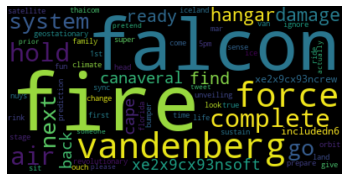

In [47]:
for keywords_year in total_keywords:
  words_list=[]
  for key,value in keywords_year.items():
    print('------------------------PLOT WORDCLOUD FOR YEAR/',year,'----------------------------')
    for word in list(value.keys()):
      words_list.append(word)
    
    words = " ".join(words_list)
    print(words)
    wordcloud = WordCloud().generate(words)

    # Display the generated image:
    # the matplotlib way:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    
  

In [48]:
df.head()

text        Date
0                            and robot spar humanity  2017-04-05
1  forin2020 exactly tesla absurdly overvalue bas...  2017-04-03
2                                 waltmossberg et tu  2017-04-03
3                          stormy weather shortville  2017-04-03
4  daveleebbc coal die due nat gas fracking basic...  2017-04-02

## **Plotting the most common words (keywords) % Date**

In [49]:
result

year                 keywords
0  2010          (ignore, 0.456)
1  2011             (van, 0.313)
2  2012            (ouch, 0.452)
3  2013         (sustain, 0.439)
4  2014            (sync, 0.378)
5  2015  (xe2x9cx93nsoft, 0.368)
6  2016          (hangar, 0.419)
7  2017       (vandenberg, 0.38)

In [50]:
frequencies = []
for l  in result.keywords:
  frequencies.append(l[1])
frequencies

[0.456, 0.313, 0.452, 0.439, 0.378, 0.368, 0.419, 0.38]

In [51]:
keywor = []
for l  in result.keywords:
  keywor.append(l[0])
keywor

['ignore',
 'van',
 'ouch',
 'sustain',
 'sync',
 'xe2x9cx93nsoft',
 'hangar',
 'vandenberg']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning:

'from_array' is deprecated and will be removed in a future version. Please use the pd.Series(..) constructor instead.



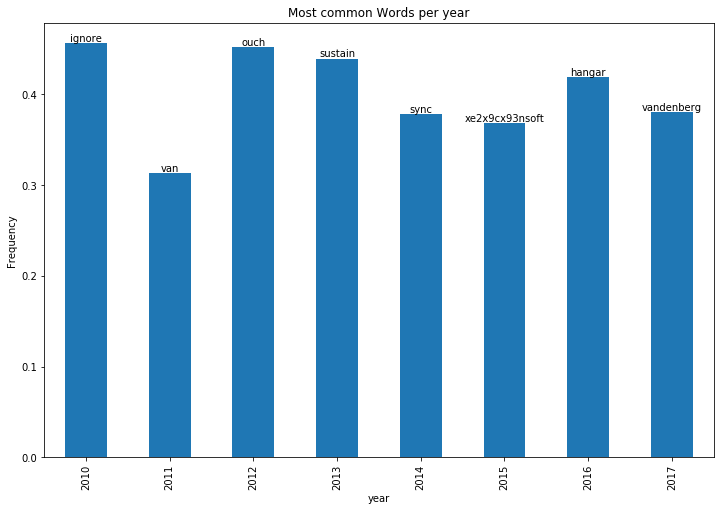

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Bring some raw data.

# In my original code I create a series and run on that, 
# so for consistency I create a series from the list.
freq_series = pd.Series.from_array(frequencies)

x_labels = years_list

# Plot the figure.
plt.figure(figsize=(12, 8))
ax = freq_series.plot(kind='bar')
ax.set_title('Most common Words per year')
ax.set_xlabel('year')
ax.set_ylabel('Frequency')
ax.set_xticklabels(x_labels)


rects = ax.patches



for rect, keyword in zip(rects, keywor):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height, keyword,
            ha='center', va='bottom')

# 6.Defining the **target** Y

In [129]:
df.head()

text        Date
0                            and robot spar humanity  2017-04-05
1  forin2020 exactly tesla absurdly overvalue bas...  2017-04-03
2                                 waltmossberg et tu  2017-04-03
3                          stormy weather shortville  2017-04-03
4  daveleebbc coal die due nat gas fracking basic...  2017-04-02

In [130]:
result.head()

year          keywords
0  2010   (ignore, 0.456)
1  2011      (van, 0.313)
2  2012     (ouch, 0.452)
3  2013  (sustain, 0.439)
4  2014     (sync, 0.378)

In [0]:
df.to_csv('/content/drive/My Drive/Projet_isid/Y.csv')

In [0]:
 df["Date"] = pd.to_datetime(df.Date, errors='coerce')

In [132]:
di = {}
for i in range(len(result)) : 
  #print(y.loc[i, "year"], y.loc[i, "keywords"])
  di[result.loc[i, "year"]] = result.loc[i, "keywords"]
di

{2010: ('ignore', 0.456),
 2011: ('van', 0.313),
 2012: ('ouch', 0.452),
 2013: ('sustain', 0.439),
 2014: ('sync', 0.378),
 2015: ('xe2x9cx93nsoft', 0.368),
 2016: ('hangar', 0.419),
 2017: ('vandenberg', 0.38)}

In [133]:
l = []
for val in di.values():
  #print(type(val))
  '''pos = 2
  s = ""
  while val[pos] != val[val.index("',")] and pos < len(val):
     s+= val[pos]
     pos += 1
  '''
  l.append(val[0])
print(l)

['ignore', 'van', 'ouch', 'sustain', 'sync', 'xe2x9cx93nsoft', 'hangar', 'vandenberg']


In [0]:
for key,val in di.items():
  for i in range(len(df)) : 
  #print(y.loc[i, "year"], y.loc[i, "keywords"])
     X_year = df.loc[i,"Date"].year 
     if key == X_year : 
        pos = 2
        s = ""
        '''while val[pos] != val[val.index("',")]:
            s+= val[pos]
            pos += 1
        '''
        df.loc[i,"Y"]= val[0]
     else:
        continue
  

In [135]:
df.head()

text       Date           Y
0                            and robot spar humanity 2017-04-05  vandenberg
1  forin2020 exactly tesla absurdly overvalue bas... 2017-04-03  vandenberg
2                                 waltmossberg et tu 2017-04-03  vandenberg
3                          stormy weather shortville 2017-04-03  vandenberg
4  daveleebbc coal die due nat gas fracking basic... 2017-04-02  vandenberg

## **Encoding the target Y**

In [0]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Y'] = le.fit_transform(df.Y)

In [0]:
Y = pd.Series(data = df.Y,name='Y')

In [0]:
x = df.copy()

In [0]:
x = x.drop(["Y"], axis=1)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test , y_train , y_test  = train_test_split(x,Y , test_size = 0.3)

# **`7.Sequence creation and Word Embedding`**

In [143]:
sentences = []
for index, row in df.iterrows():
    #print(row['c1'], row['c2'])
    s = row['text']
    sentences.append(s)
sentences

['and robot spar humanity',
 'forin2020 exactly tesla absurdly overvalue base past s irrxe2x80xa6',
 'waltmossberg et tu',
 'stormy weather shortville',
 'daveleebbc coal die due nat gas fracking basically',
 'lexxxzis helicopter s',
 'verge',
 'supercoolcube pretty',
 'why waste much time develop silly rocket damn alien obtuse crazy tech t speak',
 'technology breakthrough turn chemtrails actually message time-traveling alien describe secret',
 'rt ve create s first spam-detecting ai train entirely simulation deploy physical robot',
 'rt extremely important - reusable rocket bring us much closer become',
 'adamsbj def p100d ludicrous+ although rocket start go lot faster',
 'badastronomer def bring back like dragon question much weight need',
 'teslaaddict work',
 'jasonlamb look like could 20% structural upgrade handle high load s fully expendable',
 'cheron',
 'cardoso silly thing imagine secret payload 1st dragon flight giant wheel cheese inspire bxe2x80xa6',
 'redletterdave good po

In [144]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [145]:
from nltk.tokenize import sent_tokenize, word_tokenize 
corpus = []
for index, row in X_train.iterrows():
    #print(row['c1'], row['c2'])
    t = row['text']
    corpus.append(word_tokenize(t))
corpus

[['rt', 'model', 'arrive', 'go', 'electric', 'like', 'dylan', '#', 'ff'],
 ['torvos',
  'torque',
  'shift',
  'front',
  '&',
  'amp',
  ';',
  'rear',
  'motor',
  'every',
  '~01',
  'secs',
  'traction',
  'control',
  'way',
  'well',
  'normal',
  'awd',
  'digital',
  'v'],
 ['javashri',
  'auto',
  'import',
  'duty',
  'prohibitively',
  'high',
  'hop',
  'special',
  'category',
  'ev',
  'discussion'],
 ['trekker56',
  'please',
  'contact',
  'dmv',
  'commissioner',
  'governor',
  'good',
  'people'],
 ['ch4',
  'rapidly',
  'decay',
  'back',
  'co2',
  '&',
  'amp',
  ';',
  'absorb',
  'plant',
  'matter',
  'add',
  'new',
  'carbon',
  'surface',
  'cycle',
  'underground',
  'oil',
  'gas',
  '&',
  'amp',
  ';'],
 ['solar',
  'glass',
  'tile',
  'also',
  'incorporate',
  'heat',
  'element',
  'like',
  'rear',
  'defroster',
  'car',
  'clear',
  'roof',
  'snow',
  'keep',
  'generate'],
 ['rocketrepreneur',
  '382s',
  '150',
  'area',
  'ratio',
  'vacuum',


In [0]:
from keras.preprocessing.text import Tokenizer

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(sentences)
vocab_length = len(word_tokenizer.word_index) + 1

In [147]:
embedded_sentences = word_tokenizer.texts_to_sequences(corpus)
print(embedded_sentences)

[[1, 3, 531, 14, 168, 12, 5617, 5618], [3922, 737, 1426, 605, 6, 279, 184, 278, 3923, 1565, 305, 86, 50, 2162, 1564, 1566, 78], [4193, 227, 4194, 2239, 4195, 42, 548, 4196, 4197, 1216, 1595], [5305, 225, 931, 1678, 2448, 5306, 9, 39], [4253, 4254, 1761, 69, 581, 6, 1357, 1600, 353, 351, 24, 275, 925, 951, 4255, 1019, 230, 6], [44, 625, 1178, 47, 3165, 500, 1923, 12, 279, 3166, 8, 447, 307, 806, 382, 807], [1486, 3327, 1985, 817, 3328, 689, 880, 53, 3329, 391, 1879, 14, 3330, 247], [1660, 319, 431, 102, 23], [1297, 1324, 111, 286, 536, 4725, 47, 176], [201, 165, 60, 1487, 379, 149, 19, 404, 934, 364, 60], [2781, 239, 28, 246, 22, 420, 32, 189, 774, 134, 553, 658], [1, 324, 58, 121, 693, 1447, 2231, 2232], [202, 437, 162, 2400, 123, 5044, 709, 608, 1284, 542, 26, 55], [3587], [433, 506, 366, 399, 27, 3317, 112, 97], [1326, 800, 387, 811, 78, 578, 802, 1905], [612, 2173, 552, 833, 552, 468, 78, 5520, 1817], [274, 321, 1334, 263, 110, 43, 114, 203, 142, 936, 211, 78, 42, 165, 215, 6, 66, 5

In [0]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding

In [149]:
from nltk.tokenize import word_tokenize

word_count = lambda sentence: len(word_tokenize(sentence))
longest_sentence = max(sentences, key=word_count)
length_long_sentence = len(word_tokenize(longest_sentence))

padded_sentences = pad_sequences(embedded_sentences, length_long_sentence, padding='post')

print(padded_sentences)

[[   1    3  531 ...    0    0    0]
 [3922  737 1426 ...    0    0    0]
 [4193  227 4194 ...    0    0    0]
 ...
 [ 797 6023 6024 ...    0    0    0]
 [2769  102    0 ...    0    0    0]
 [3025  893 1157 ...    0    0    0]]


In [0]:
row_sums = padded_sentences.sum(axis=1)
padded_sentences = padded_sentences / row_sums[:, np.newaxis]



In [151]:
padded_sentences

array([[8.35840856e-05, 2.50752257e-04, 4.43831494e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.09329633e-01, 3.93360376e-02, 7.61101623e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.56210417e-01, 8.45689591e-03, 1.56247672e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [3.83541867e-02, 2.89846006e-01, 2.89894129e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.64472309e-01, 3.55276907e-02, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.65164797e-01, 7.82784011e-02, 1.01420056e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [0]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding

In [153]:
from nltk.tokenize import sent_tokenize, word_tokenize 
target = []
for x in y_train:
    #print(row['c1'], row['c2'])
    
    target.append(x)
target

[2,
 0,
 7,
 3,
 7,
 0,
 0,
 3,
 4,
 0,
 6,
 7,
 3,
 0,
 0,
 3,
 3,
 3,
 4,
 7,
 2,
 6,
 3,
 3,
 0,
 4,
 3,
 0,
 0,
 4,
 6,
 0,
 6,
 0,
 0,
 0,
 7,
 2,
 3,
 7,
 6,
 4,
 0,
 2,
 7,
 3,
 3,
 5,
 0,
 6,
 0,
 0,
 4,
 4,
 2,
 3,
 6,
 0,
 6,
 0,
 4,
 0,
 3,
 0,
 3,
 7,
 7,
 4,
 6,
 0,
 0,
 3,
 0,
 3,
 5,
 0,
 4,
 0,
 0,
 4,
 7,
 2,
 6,
 0,
 3,
 7,
 7,
 3,
 2,
 0,
 0,
 0,
 7,
 7,
 3,
 7,
 2,
 2,
 6,
 7,
 0,
 4,
 7,
 0,
 0,
 6,
 0,
 4,
 0,
 7,
 7,
 3,
 6,
 3,
 5,
 4,
 6,
 6,
 3,
 0,
 6,
 4,
 6,
 0,
 2,
 7,
 7,
 2,
 7,
 3,
 0,
 3,
 7,
 6,
 3,
 4,
 0,
 0,
 7,
 6,
 4,
 0,
 3,
 0,
 0,
 0,
 0,
 3,
 0,
 7,
 4,
 7,
 2,
 3,
 0,
 3,
 0,
 3,
 0,
 2,
 3,
 0,
 6,
 6,
 6,
 0,
 0,
 0,
 2,
 4,
 0,
 6,
 6,
 7,
 3,
 4,
 7,
 6,
 4,
 7,
 0,
 6,
 2,
 6,
 4,
 4,
 6,
 2,
 0,
 0,
 3,
 0,
 0,
 3,
 6,
 3,
 3,
 0,
 0,
 2,
 4,
 3,
 7,
 0,
 3,
 3,
 3,
 6,
 4,
 7,
 4,
 2,
 3,
 7,
 0,
 0,
 2,
 7,
 6,
 2,
 0,
 0,
 3,
 0,
 6,
 3,
 7,
 0,
 2,
 6,
 0,
 3,
 7,
 7,
 3,
 0,
 0,
 0,
 0,
 7,
 7,
 7,
 7,
 5,
 0,
 2,
 6,
 0,
 0,
 0,


In [0]:
#embedded_target = [one_hot(sent, vocab_length) for sent in target]
p#rint(embedded_target )

In [0]:
'''tar = []
for elt in embedded_target :
  tar.append(elt[0])
tar'''

In [0]:
'''from sklearn import preprocessing
t = preprocessing.normalize([tar])
t'''

In [0]:
X = []
sentences = list(df["text"])
for sen in sentences:
    X.append(sen)



In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [156]:
X_train.head()

AttributeError: ignored

In [157]:
y_train.head()

2243    3
2189    3
2710    2
2673    2
1027    0
Name: Y, dtype: int64

In [0]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [161]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-01-05 23:58:43--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-01-05 23:58:43--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-01-05 23:58:44--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove

In [162]:
!unzip glove*.zip

Archive:  glove.6B.zip
replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [0]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = {}

glove_file = open('/content/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

# **8.Building The model**

In [164]:
from keras.layers import Dropout
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
model.add(embedding_layer)
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1973, activation='sigmoid'))













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [165]:
from keras.optimizers import Adam
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False)
model.compile(optimizer = adam, loss='sparse_categorical_crossentropy', metrics=['acc'])


In [166]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 100)          532700    
_________________________________________________________________
lstm_1 (LSTM)                (None, 200, 64)           42240     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200, 64)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1973)              128245    
Total params: 736,209
Trainable params: 203,509
Non-trainable params: 532,700
__________________________________________

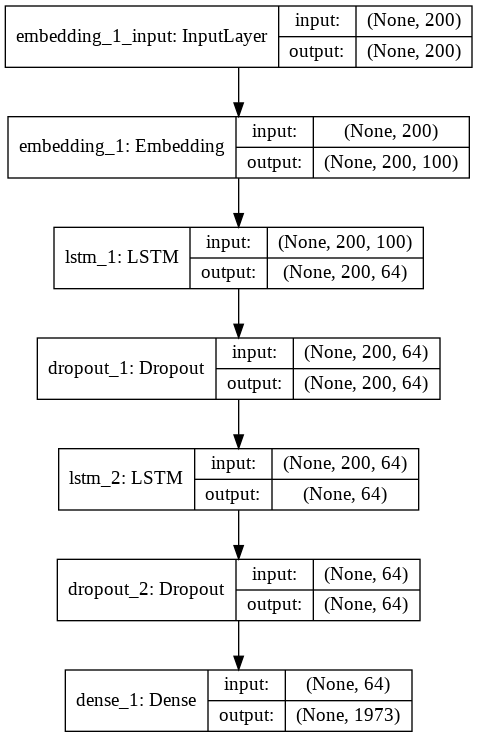

In [167]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

In [82]:
history =model.fit(X_train, y_train, batch_size=128, epochs=100, verbose=1, validation_split=0.2)

Train on 1804 samples, validate on 451 samples
Epoch 1/100
1804/1804 [==============================] - 11s 6ms/step - loss: 2.3632 - acc: 0.3165 - val_loss: 2.2862 - val_acc: 0.3570
Epoch 2/100
1804/1804 [==============================] - 11s 6ms/step - loss: 2.2703 - acc: 0.3182 - val_loss: 2.2092 - val_acc: 0.3570
Epoch 3/100
1804/1804 [==============================] - 10s 6ms/step - loss: 2.2114 - acc: 0.3182 - val_loss: 2.1523 - val_acc: 0.3570
Epoch 4/100
1804/1804 [==============================] - 11s 6ms/step - loss: 2.1562 - acc: 0.3187 - val_loss: 2.1111 - val_acc: 0.3570
Epoch 5/100
1804/1804 [==============================] - 11s 6ms/step - loss: 2.1219 - acc: 0.3215 - val_loss: 2.0787 - val_acc: 0.3570
Epoch 6/100
1804/1804 [==============================] - 11s 6ms/step - loss: 2.0890 - acc: 0.3215 - val_loss: 2.0529 - val_acc: 0.3570
Epoch 7/100
1804/1804 [==============================] - 11s 6ms/step - loss: 2.0704 - acc: 0.3232 - val_loss: 2.0318 - val_acc: 0.3570
E

In [83]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

564/564 [==============================] - 1s 2ms/step
Test Score: 1.8134143775236522
Test Accuracy: 0.3421985815602837


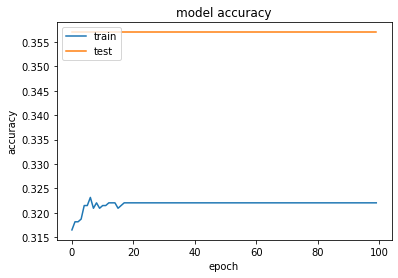

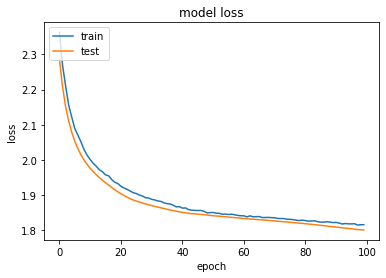

In [84]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# Prediction

In [0]:
y_pred = model.predict(X_test)
y_pred

array([[0.9897373 , 0.00201795, 0.98025656, ..., 0.00191966, 0.00228137,
        0.00140181],
       [0.9897373 , 0.00201795, 0.98025656, ..., 0.00191966, 0.00228137,
        0.00140181],
       [0.9897373 , 0.00201795, 0.98025656, ..., 0.00191966, 0.00228137,
        0.00140181],
       ...,
       [0.9897373 , 0.00201795, 0.98025656, ..., 0.00191966, 0.00228137,
        0.00140181],
       [0.9897374 , 0.00201795, 0.9802566 , ..., 0.00191966, 0.00228137,
        0.00140181],
       [0.9897374 , 0.00201795, 0.9802566 , ..., 0.00191965, 0.00228133,
        0.00140179]], dtype=float32)

In [0]:
y_pred[0]

In [0]:
x = np.max(y_pred[0])
x

0.9897373

In [0]:
i = list(y_pred[0]).index(x)
i

0

In [0]:
label = ta[i]
label

NameError: ignored

In [0]:
label = le.inverse_transform([x])
label

array([0])

In [0]:
y_test.iloc[0]